# Setup

In [1]:
import os
import sys
import subprocess
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import scipy as sp

import anndata as ad
import scanpy as sc

### User variables

In [2]:
RUN_ID = "sep8"

In [3]:
PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
HCA_BORGS_PROJ = "data/datasets/hca_brain-organoids/"
ATAC_PEAKS_PATH = "data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss.h5ad"
RNA_AD_PATH = os.path.join(HCA_BORGS_PROJ, "outputs_allsamples/sabrina_allsamples_rna_after_atac.h5ad")

In [4]:
bedtools_bin = '/home/fichtner/.conda/envs/ian/bin/bedtools'

In [5]:
min_donors= 0.2 # Minimum percentage of donors (cell aggregates) a peak needs to be found in AKA Peak sparsity filter
min_cells = 10 # Minimum amount of cells a peak needs to for the peak to be retained (required for functions to work)
cell_type = str("Differentiating RG")
min_pval = 0.01 # Min p-value for marker peaks to be considered in the first place in differential peak accessibility
top_n_markers = 2000 # Top n ranking markers peaks to consider
min_peak_mean_adonors = 0.002 # Minimum threshold of peak mean across donors# Convert sparse matrix to dense format if necessary
min_score = 9 # Minimum score (resulting -log10(q-val) of peak calling w MACS2

### Variables

In [6]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt

In [7]:
cell_type_alt = ct_format_alt(cell_type)
cell_type = ct_format(cell_type)

### Artifact donors

In [8]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [9]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# Get data

## Chromatin accessibility cell-level anndata

In [10]:
borgs_tile_mat = ad.read_h5ad(ATAC_PEAKS_PATH)

# Format
borgs_tile_mat.var_names = borgs_tile_mat.var['peak_name']
borgs_tile_mat.obs['celltype'] = borgs_tile_mat.obs['celltype'].apply(ct_format).astype('category')

borgs_tile_mat

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 288900 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'celltype', 'cellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'Batch', 'ReadsInPeaks', 'FRIP', 'barcode'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [11]:
# Remove artifact donors
donors_qc = ~borgs_tile_mat.obs['donor_id'].isin(artifact_donors)

borgs_tile_mat = borgs_tile_mat[donors_qc, :].copy()

borgs_tile_mat.shape

(284522, 736845)

### Get cell-type anndata

In [12]:
caPeaks_1ct = borgs_tile_mat[borgs_tile_mat.obs['celltype'] == cell_type, :].copy()
caPeaks_1ct

AnnData object with n_obs × n_vars = 4601 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'celltype', 'cellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'Batch', 'ReadsInPeaks', 'FRIP', 'barcode'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [13]:
n_peaks_og = caPeaks_1ct.n_vars

### Hard peak filter: Remove peaks w min cell nr

In [14]:
# Required for HVPeaks or DAPeaks algorithms
sc.pp.filter_genes(caPeaks_1ct, min_cells=min_cells)
n_cells, n_peaks_post_min_cells = caPeaks_1ct.shape
caPeaks_1ct.shape

(4601, 473392)

In [15]:
n_peaks_min_cells = n_peaks_og - n_peaks_post_min_cells

In [16]:
# Remove hard-filtered peaks from cell-level anndata = borgs_tile_mat[].
# borgs_tile_mat = borgs_tile_mat[].
borgs_tile_mat = borgs_tile_mat[:, caPeaks_1ct.var_names].copy()

### Cell-type cells level stats

In [17]:
# describe_result = sp.stats.describe(caPeaks_1ct.X.toarray(), axis=0)

# stats = {
#     'nobs': [describe_result.nobs] * len(describe_result.mean),
#     'min': describe_result.minmax[0],
#     'max': describe_result.minmax[1],
#     'mean': describe_result.mean,
#     'variance': describe_result.variance,
#     'skewness': describe_result.skewness,
#     'kurtosis': describe_result.kurtosis
# }

# # Create a DataFrame with the statistics
# df = pd.DataFrame(stats)
# df = df.transpose().reset_index().rename(columns={'index': 'statistic'}).set_index('statistic')

# df

### Init donor-level CA matrix

In [18]:
caPeaks_1ct_agg = sc.get.aggregate(caPeaks_1ct,
                                   by=['donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_1ct_agg.X = caPeaks_1ct_agg.layers['mean'].copy()
del caPeaks_1ct_agg.layers['mean']

n_donors = caPeaks_1ct_agg.n_obs

caPeaks_1ct_agg

AnnData object with n_obs × n_vars = 68 × 473392
    obs: 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type', 'n_cells'

In [19]:
agg_df = caPeaks_1ct_agg.to_df()
agg_df

peak_name,chr1:817077:817577:501:*:3,chr1:819782:820282:501:*:5,chr1:826617:827117:501:*:6,chr1:827319:827819:501:*:7,chr1:858597:859097:501:*:12,chr1:869651:870151:501:*:13,chr1:870332:870832:501:*:14,chr1:901158:901658:501:*:17,chr1:901967:902467:501:*:18,chr1:903269:903769:501:*:19,...,chrX:155820072:155820572:501:*:19663,chrX:155845180:155845680:501:*:19664,chrX:155864598:155865098:501:*:19665,chrX:155880442:155880942:501:*:19669,chrX:155881013:155881513:501:*:19670,chrX:155881586:155882086:501:*:19671,chrX:155888143:155888643:501:*:19672,chrX:155889305:155889805:501:*:19673,chrX:155956608:155957108:501:*:19676,chrX:155966839:155967339:501:*:19678
SAMEA2420640,0.000000,0.021425,0.000000,0.125175,0.000000,0.021425,0.000000,0.000000,0.021425,0.000000,...,0.013692,0.104023,0.000000,0.021425,0.020631,0.018210,0.051233,0.000000,0.013556,0.000000
SAMEA2433566,0.174626,0.000000,0.000000,0.181276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMEA2445779,0.000000,0.000000,0.003041,0.054691,0.004567,0.039639,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019565,0.000000,0.008008,0.104270,0.000000,0.000000,0.005153,0.000000,0.000000
SAMEA2445784,0.000000,0.000000,0.000996,0.049289,0.000000,0.043822,0.002139,0.000000,0.000000,0.000000,...,0.011549,0.018151,0.000000,0.008103,0.045994,0.007137,0.016424,0.015224,0.012142,0.006415
SAMEA2459959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA3977051,0.000000,0.000000,0.009235,0.042855,0.000000,0.000000,0.000000,0.009235,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.026872,0.164967,0.016583,0.011441,0.116375,0.000000,0.033320
SAMEA4089453,0.000000,0.000000,0.015494,0.136952,0.000000,0.102309,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.038358,0.099323,0.015494,0.000000,0.000000,0.000000,0.000000
SAMEA4343052,0.001993,0.000000,0.003623,0.075067,0.000526,0.027788,0.000891,0.001515,0.000867,0.001556,...,0.014217,0.004999,0.001644,0.002196,0.084786,0.007561,0.005815,0.000000,0.000000,0.002252
SAMEA4451098,0.000000,0.016682,0.000000,0.086172,0.000000,0.053786,0.000000,0.000000,0.000000,0.010832,...,0.000000,0.021694,0.000000,0.038377,0.050928,0.051134,0.035362,0.000000,0.025567,0.000000


### Init donor-batch-level CA matrix

In [20]:
caPeaks_agg_cdb = sc.get.aggregate(borgs_tile_mat,
                                   by=['celltype', 'donor_id', 'Batch'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_agg_cdb.X = caPeaks_agg_cdb.layers['mean'].copy()
del caPeaks_agg_cdb.layers['mean']

n_donor_batch = caPeaks_agg_cdb.obs[caPeaks_agg_cdb.obs['celltype'] == cell_type].shape[0]

caPeaks_agg_cdb

AnnData object with n_obs × n_vars = 3440 × 473392
    obs: 'celltype', 'donor_id', 'Batch'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

# Cell-level analysis

## Peak filter: DAPeaks

In [21]:
from scipy.sparse import csr_matrix, issparse

if issparse(caPeaks_agg_cdb.X):
    print("SCIPY sparse matrix.")
    if np.any(caPeaks_agg_cdb.X.data < 0):
        print("There are negative values in the sparse data matrix.")
    else:
        print("No negative values in the sparse data matrix.")
else:
    print(f"X type:\n{type(caPeaks_agg_cdb.X)}")
    if np.any(caPeaks_agg_cdb.X < 0):
        print("There are negative values in the dense data matrix.")
    else:
        print("No negative values in the dense data matrix.")

X type:
<class 'numpy.ndarray'>
No negative values in the dense data matrix.


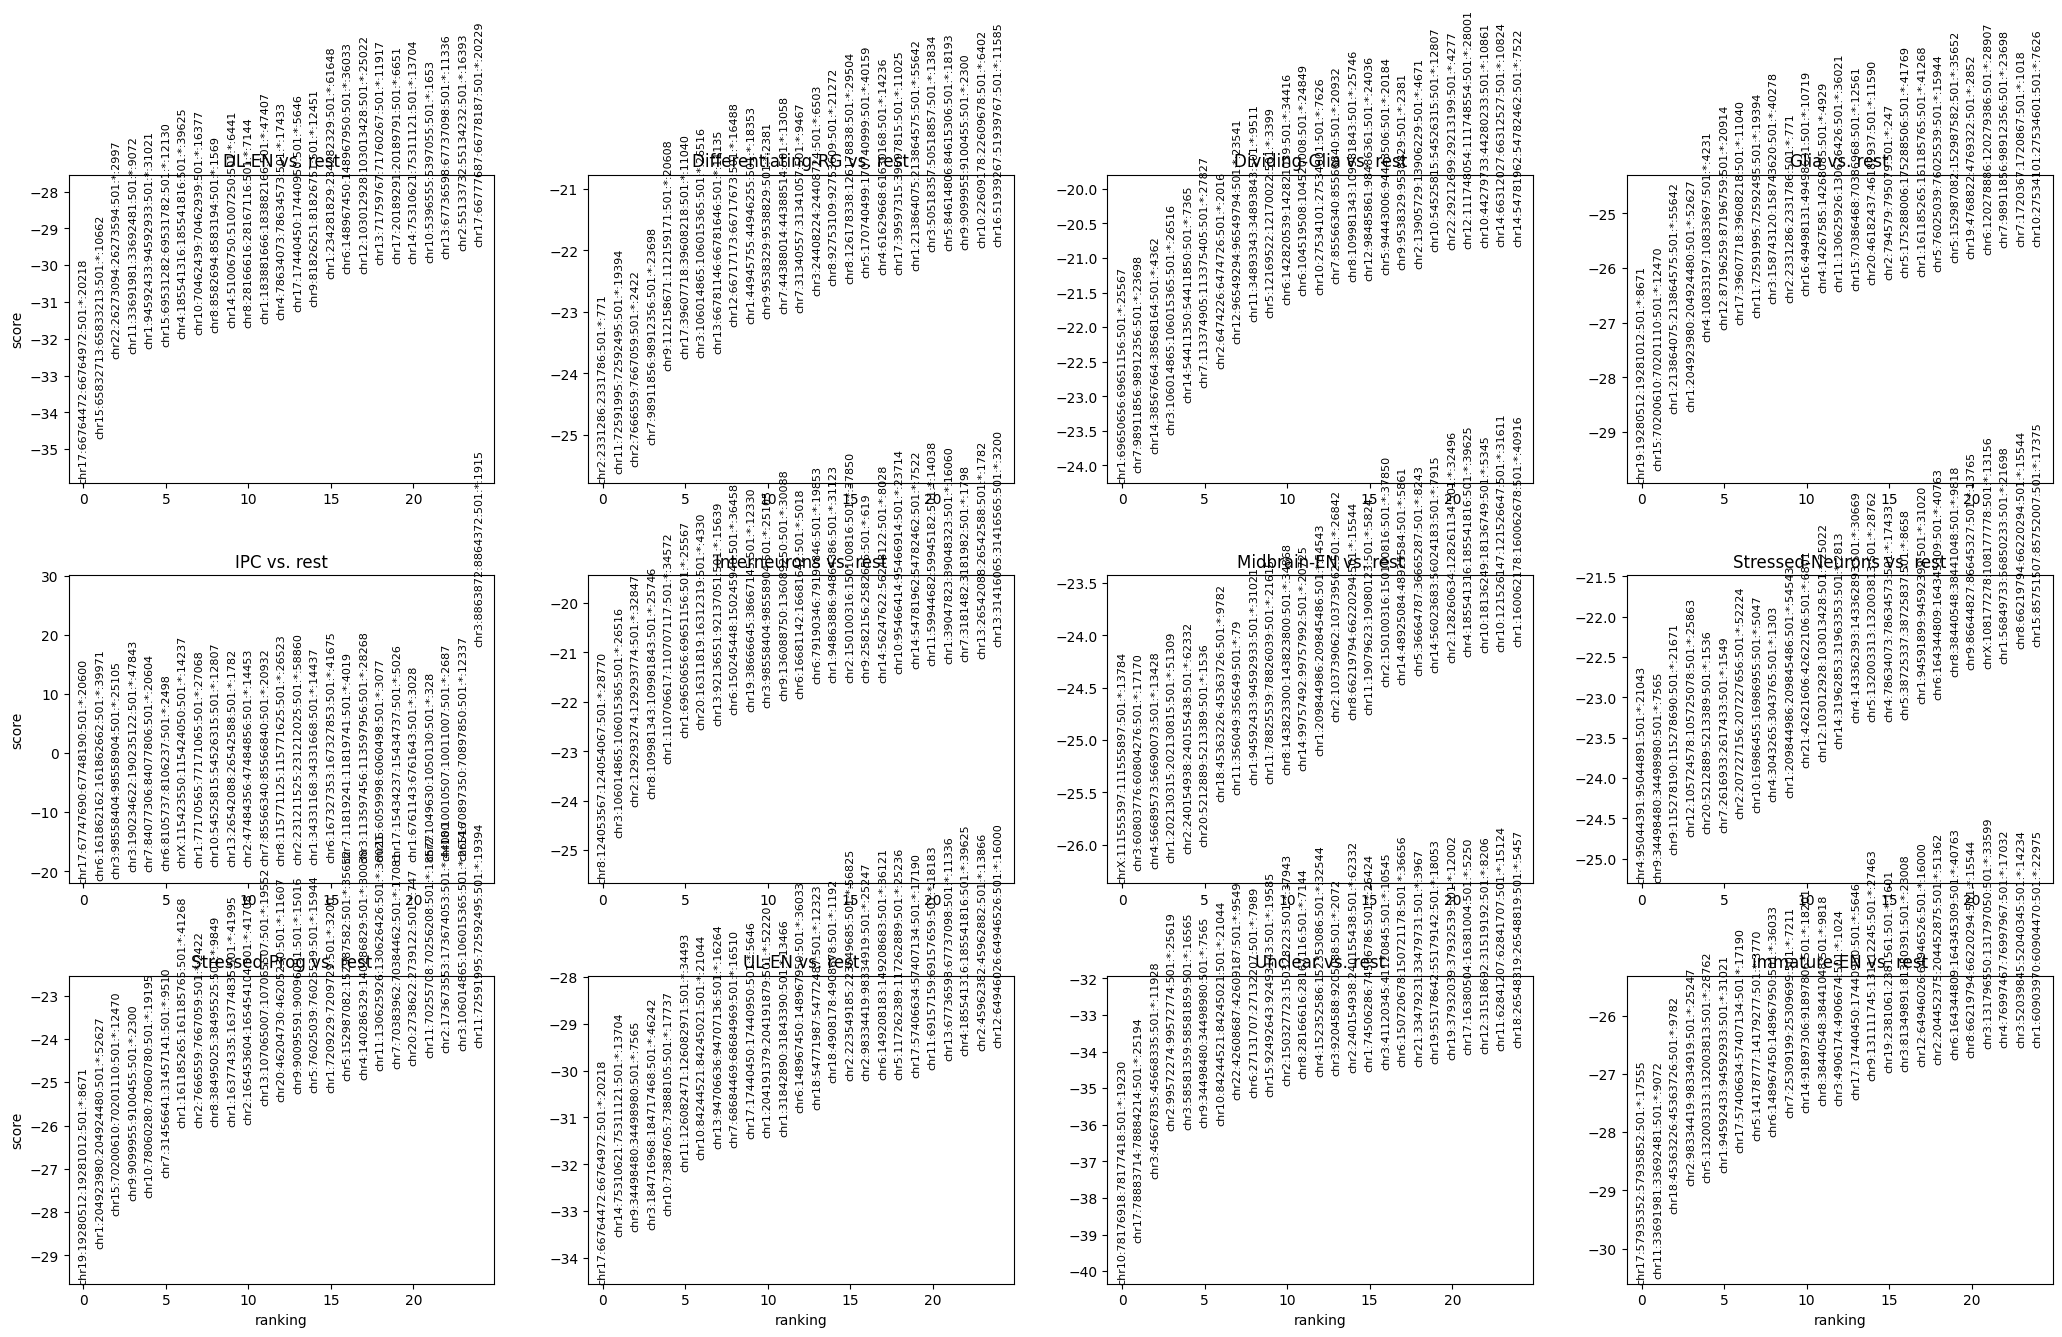

In [22]:
sc.tl.rank_genes_groups(caPeaks_agg_cdb, groupby='celltype', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(caPeaks_agg_cdb, n_genes=25, sharey=False)

In [23]:
daps = sc.get.rank_genes_groups_df(caPeaks_agg_cdb, group=cell_type, pval_cutoff=min_pval)
peaks_markers = set(daps['names'][0:top_n_markers])
daps

,names,scores,logfoldchanges,pvals,pvals_adj
0,chr2:2331286:2331786:501:*:771,-25.780697,-4.144169,7.164268e-134,3.391507e-128
1,chr11:72591995:72592495:501:*:19394,-25.623331,-4.239567,1.156963e-132,2.738485e-127
2,chr2:7666559:7667059:501:*:2422,-25.502314,-3.231615,8.970722e-121,1.061667e-115
3,chr7:98911856:98912356:501:*:23698,-25.158312,-4.490247,9.786121e-127,1.544224e-121
4,chr9:112158671:112159171:501:*:20608,-23.943132,-3.925020,4.706915e-117,4.456432e-112
...,...,...,...,...,...
64535,chr6:20919786:20920286:501:*:6159,-3.206677,-1.931442,1.355275e-03,9.954017e-03
64536,chr6:22099149:22099649:501:*:6602,-3.206421,-1.905199,1.361204e-03,9.988422e-03
64537,chr16:52650461:52650961:501:*:11816,-3.206198,-1.687001,1.360083e-03,9.981590e-03
64538,chr4:153138719:153139219:501:*:32788,-3.205813,-1.885510,1.361348e-03,9.989051e-03


In [24]:
daps.to_csv(f"data/datasets/hca_brain-organoids_processed/chromatin_accessibility/differentially-accessible-peaks_{cell_type}.tsv",
            sep='\t')

In [25]:
del caPeaks_agg_cdb

## Peaks filter: intersecting w eQTLs

### Make eQTLs bed file

In [ ]:
eqtls = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "eQTL_mapping/eSNPs_significant_all_celltypes_HVGs.tsv"),
                   sep='\t',
                   header=0,
                   index_col=21)
eqtls.columns

Index(['snp_id', 'p_value', 'beta', 'beta_se', 'empirical_feature_p_value',
       'feature_chromosome', 'feature_start', 'feature_end', 'gene_name',
       'n_samples', 'n_e_samples', 'alpha_param', 'beta_param', 'rho',
       'snp_chromosome', 'snp_position', 'assessed_allele', 'call_rate', 'maf',
       'hwe_p', 'feature_id', 'global_corrected_pValue',
       'global_corrected_pValue_BH', 'global_corrected_pValue_BF', 'celltype'],
      dtype='object')

In [27]:
eqtls

,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,gene_name,n_samples,...,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,global_corrected_pValue,global_corrected_pValue_BH,global_corrected_pValue_BF,celltype
QTL,,,,,,,,,,,,,,,,,,,,,
ENSG00000269376-chr13_112983450_T_C,chr13_112983450_T_C,0.000066,-0.364427,0.092665,0.000000e+00,13,113009671,113010319,NaN,277,...,112983450,C,1.0,0.044776,1.000000,ENSG00000269376,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000183463-chr13_27824764_C_T,chr13_27824764_C_T,0.047441,-0.089739,0.045430,0.000000e+00,13,27977717,27988693,URAD,277,...,27824764,C,1.0,0.089552,0.073438,ENSG00000183463,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000259182-chr15_101221494_A_C,chr15_101221494_A_C,0.202509,-0.088910,0.069866,0.000000e+00,15,101168530,101170821,NaN,277,...,101221494,A,1.0,0.044776,0.110206,ENSG00000259182,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286922-chr12_127567286_A_G,chr12_127567286_A_G,0.265404,-0.030918,0.027792,0.000000e+00,12,127486938,127533242,NaN,277,...,127567286,G,1.0,0.074627,1.000000,ENSG00000286922,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286246-chr12_129375924_C_G,chr12_129375924_C_G,0.949835,-0.000101,0.001608,4.101945e-163,12,129622929,129625366,NaN,277,...,129375924,C,1.0,0.089552,0.073438,ENSG00000286246,1.930191e-161,2.223254e-161,1.111627e-160,immature_EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250842-chr5_145190494_A_T,chr5_145190494_A_T,0.000033,0.535958,0.130797,1.828702e-02,5,145337932,145381670,NaN,310,...,145190494,A,1.0,0.316176,1.000000,ENSG00000250842,4.610052e-02,4.610052e-02,1.000000e+00,Differentiating_RG
ENSG00000267537-chr19_28873752_G_A,chr19_28873752_G_A,0.000285,-0.620958,0.172965,1.854836e-02,19,28602379,28648303,NaN,310,...,28873752,G,1.0,0.066176,0.246147,ENSG00000267537,4.669823e-02,4.669823e-02,1.000000e+00,Differentiating_RG
ENSG00000287056-chr6_168100952_C_G,chr6_168100952_C_G,0.001926,-0.216988,0.070509,1.932144e-02,6,168217032,168220262,NaN,310,...,168100952,C,1.0,0.102941,1.000000,ENSG00000287056,4.858106e-02,4.858106e-02,1.000000e+00,Differentiating_RG


In [28]:
eqtls['celltype'].unique()

array(['immature_EN', 'Stressed_Prog', 'IPC', 'Glia', 'UL-EN',
       'Midbrain_EN', 'Dividing_Glia', 'DL-EN', 'Interneurons',
       'Stressed_Neurons', 'Differentiating_RG'], dtype=object)

In [29]:
cell_type_alt

'Differentiating_RG'

In [30]:
# Make eQTL bed file

eqtls_bed = eqtls[['snp_chromosome', 'snp_position', 'beta']].copy()
# eqtls_bed = eqtls.loc[eqtls['celltype'] == cell_type_alt, ['snp_chromosome', 'snp_position', 'beta']]

eqtls_bed['start'] = eqtls_bed['snp_position'] - 1 # Make index 0-based open
eqtls_bed['strand'] = '+'
eqtls_bed.reset_index(inplace=True)
eqtls_bed['chr'] = 'chr' + eqtls_bed['snp_chromosome'].astype(str)
eqtls_bed = eqtls_bed.rename(columns={'snp_position': 'end', 'QTL': 'id', 'beta': 'score'})

eqtls_bed = eqtls_bed[['chr', 'start', 'end', 'id', 'score', 'strand']].sort_values(by=['chr', 'start'], ascending=[True, True])
        
eqtls_bed_path = f'data/datasets/hca_brain-organoids_processed/eQTLs/eQTLs_{cell_type}.tsv'
eqtls_bed.to_csv(eqtls_bed_path, sep='\t', header=False, index=False)

print(len(eqtls_bed))
eqtls_bed

2470


,chr,start,end,id,score,strand
921,chr1,1050079,1050080,ENSG00000186827-chr1_1050080_T_C,-0.002860,+
818,chr1,1169857,1169858,ENSG00000187961-chr1_1169858_T_C,0.436706,+
1967,chr1,1254680,1254681,ENSG00000225285-chr1_1254681_A_G,-0.251069,+
897,chr1,2283681,2283682,ENSG00000272161-chr1_2283682_C_T,-0.000118,+
1906,chr1,2370251,2370252,ENSG00000224387-chr1_2370252_G_A,-0.000220,+
...,...,...,...,...,...,...
478,chr9,136443069,136443070,ENSG00000279141-chr9_136443070_G_A,-0.020974,+
789,chr9,136937291,136937292,ENSG00000184709-chr9_136937292_T_C,1.331115,+
2163,chr9,137021089,137021090,ENSG00000275549-chr9_137021090_C_T,-0.005619,+
805,chr9,137096077,137096078,ENSG00000176884-chr9_137096078_T_C,0.652370,+


### Make peaks bed file

In [31]:
peaks_bed = borgs_tile_mat.var[['chr', 'start', 'end', 'peak_name', 'score']].copy()
peaks_bed['start'] = peaks_bed['start'] - 1
peaks_bed['strand'] = '+'

peaks_bed_path = f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}.bed'
peaks_bed.to_csv(peaks_bed_path, sep='\t', header=False, index=False)

print(len(peaks_bed))
peaks_bed

473392


,chr,start,end,peak_name,score,strand
peak_name,,,,,,
chr1:817077:817577:501:*:3,chr1,817076,817577,chr1:817077:817577:501:*:3,19.46110,+
chr1:819782:820282:501:*:5,chr1,819781,820282,chr1:819782:820282:501:*:5,2.71269,+
chr1:826617:827117:501:*:6,chr1,826616,827117,chr1:826617:827117:501:*:6,12.61770,+
chr1:827319:827819:501:*:7,chr1,827318,827819,chr1:827319:827819:501:*:7,60.61670,+
chr1:858597:859097:501:*:12,chr1,858596,859097,chr1:858597:859097:501:*:12,9.48627,+
...,...,...,...,...,...,...
chrX:155881586:155882086:501:*:19671,chrX,155881585,155882086,chrX:155881586:155882086:501:*:19671,9.61833,+
chrX:155888143:155888643:501:*:19672,chrX,155888142,155888643,chrX:155888143:155888643:501:*:19672,26.48880,+
chrX:155889305:155889805:501:*:19673,chrX,155889304,155889805,chrX:155889305:155889805:501:*:19673,9.25191,+


### Peaks intersecting w eQTLs

In [32]:
try:
    result = subprocess.run([bedtools_bin, 'intersect' , '-a', peaks_bed_path, '-b', eqtls_bed_path, '-u'], text=True, capture_output=True)

    with open(f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}_filt-eqtls.bed', 'w') as f:
        f.write(result.stdout)

    peaks_eqtl = set([i.split('\t')[3] for i in result.stdout.split('\n')[:-1]])
    
except subprocess.CalledProcessError as e:
    
    print(f"Command failed with error: {e.stderr}")

In [33]:
del borgs_tile_mat

# Cell-type level analysis

### Peak filter: HVPeaks

In [34]:
# Remove batches w with min cell nr
cell_counts_per_donor_batch = caPeaks_1ct.obs.groupby('Batch').transform('size')
ca_1ct_batch_filtered = caPeaks_1ct[cell_counts_per_donor_batch >= 10, :].copy()
sum(cell_counts_per_donor_batch >= 10)

4529

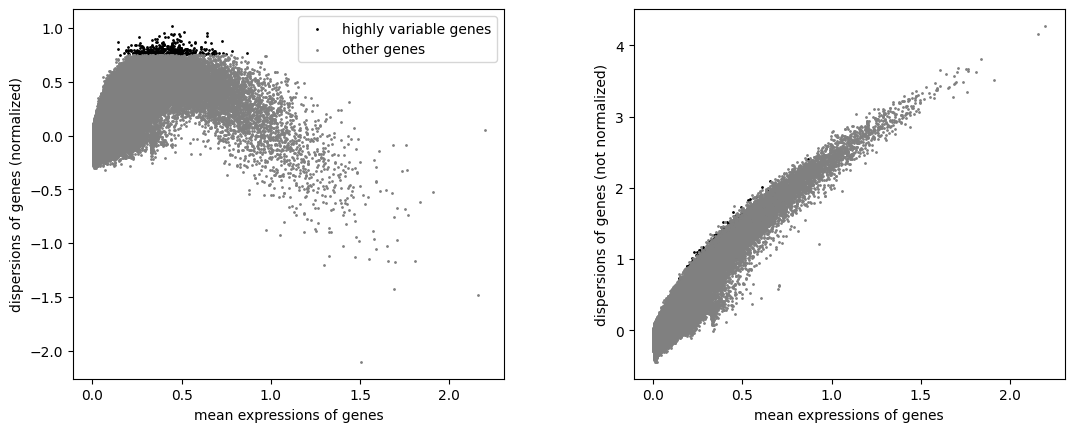

In [35]:
# Seurat (expect log)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat', batch_key='Batch', min_mean=0.0005, max_mean=3, min_disp=0.75)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [36]:
peaks_hvp = set(ca_1ct_batch_filtered.var[ca_1ct_batch_filtered.var['highly_variable']].index)

In [37]:
# !!! Below all change .var['highly_variable'], but it's okay if we don't use that info anymore downstream

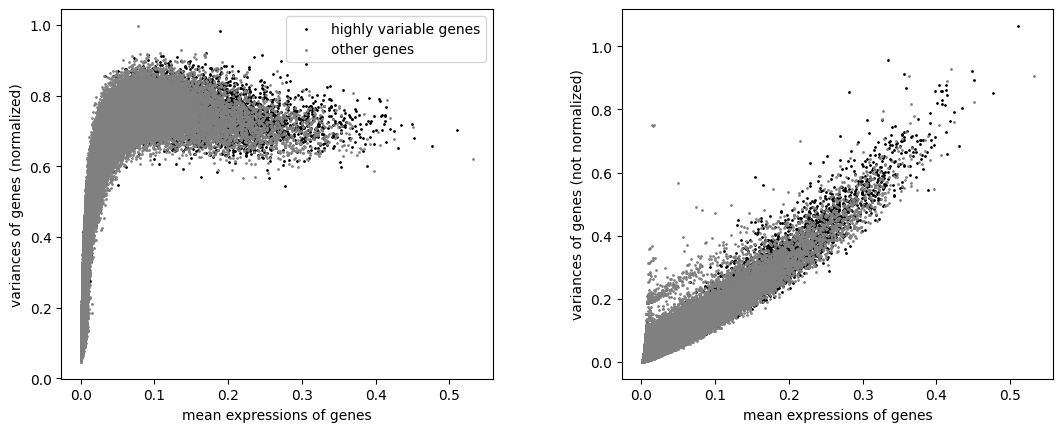

In [38]:
# Seurat_3 (expects counts)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat_v3', batch_key='Batch', n_top_genes=20000, check_values=False, span= 0.5)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

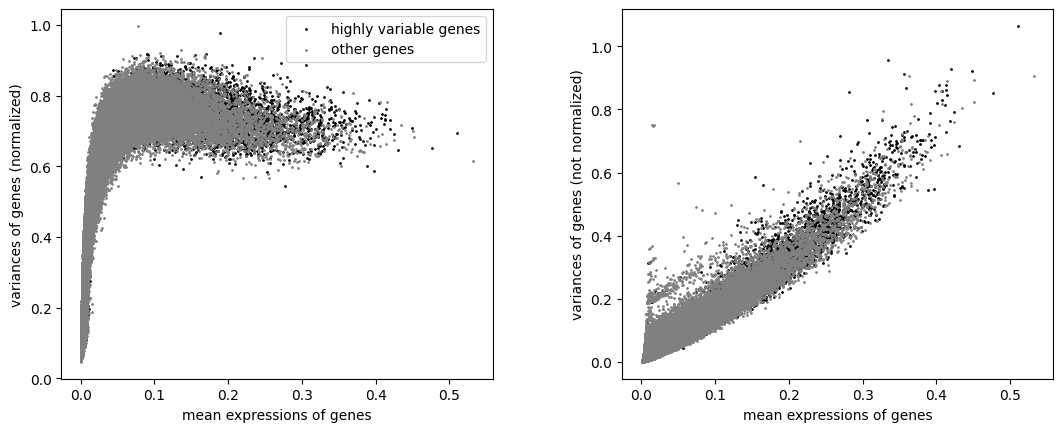

In [39]:
# Seurat_3 (expects counts)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat_v3', batch_key='Batch', n_top_genes=20000, check_values=False, span= 0.7)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

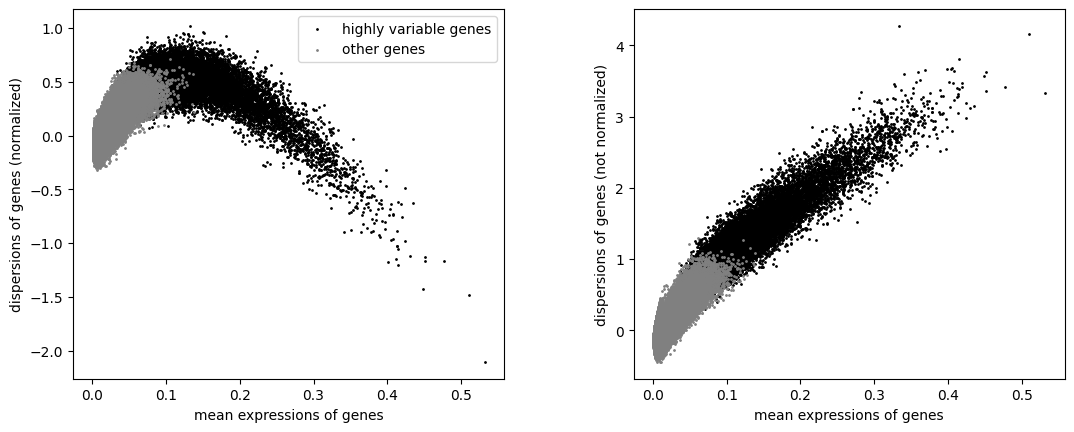

In [40]:
# Pearson residuals (expects counts)
sc.experimental.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='pearson_residuals', theta=100, batch_key='Batch', n_top_genes=20000, check_values=False)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [41]:
from scipy.sparse import issparse

# Convert sparse matrix to dense format if necessary
data_matrix = caPeaks_1ct.X.toarray() if issparse(caPeaks_1ct.X) else caPeaks_1ct.X

# Check for NaN values
print("Number of NaN values in data:", np.isnan(data_matrix).sum())

# Check for infinite values
print("Number of infinite values in data:", np.isinf(data_matrix).sum())

# Check for rows with all zeros (optimized for sparse matrices)
if issparse(caPeaks_1ct.X):
    zero_rows = np.array((caPeaks_1ct.X != 0).sum(axis=1)).flatten() == 0
else:
    zero_rows = np.sum(data_matrix == 0, axis=1) == data_matrix.shape[1]

print("Number of rows with all zero values:", zero_rows.sum())

Number of NaN values in data: 0
Number of infinite values in data: 0
Number of rows with all zero values: 0


In [42]:
# caPeaks_1ct.layers['og'] = caPeaks_1ct.X.copy()

# sc.pp.log1p(caPeaks_1ct)

In [43]:
# # Seurat (expect log)
# sc.pp.highly_variable_genes(caPeaks_1ct, flavor='seurat', batch_key='Batch', min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(caPeaks_1ct)

In [44]:
# # Seurat_3 (expects counts)
# sc.pp.highly_variable_genes(caPeaks_1ct, flavor='seurat_v3', batch_key='Batch', n_top_genes=50000, check_values=False, span= 0.5)
# sc.pl.highly_variable_genes(caPeaks_1ct)

In [45]:
# caPeaks_1ct.X = caPeaks_1ct.layers['og'].copy()
# del caPeaks_1ct.layers['og']

In [46]:
del ca_1ct_batch_filtered

## Peaks filter: min mean across donors

In [47]:
agg_mean = agg_df.mean()

In [48]:
agg_mean.describe()

count    473392.000000
mean          0.011881
std           0.027000
min           0.000142
25%           0.001778
50%           0.003628
75%           0.009303
max           0.515999
dtype: float64

<Axes: title={'center': 'Peak mean across donors distr.'}, ylabel='#'>

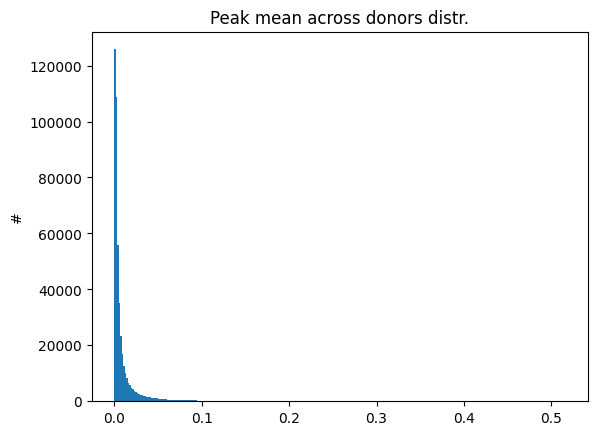

In [49]:
agg_mean.plot(kind='hist',
              bins=300, title="Peak mean across donors distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='#'>

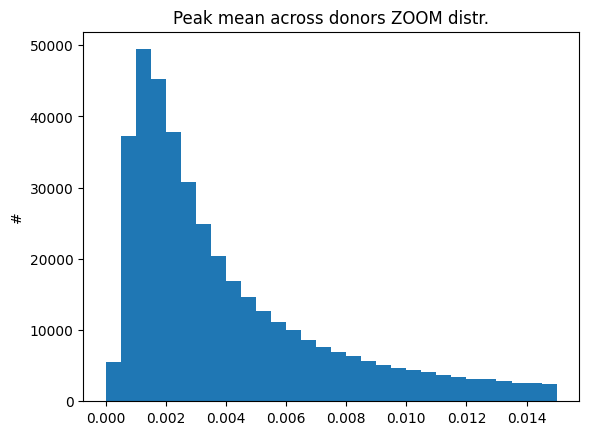

In [50]:
agg_mean.plot(kind='hist', 
              bins=np.linspace(0, 0.015, 31),
              title="Peak mean across donors ZOOM distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='Density'>

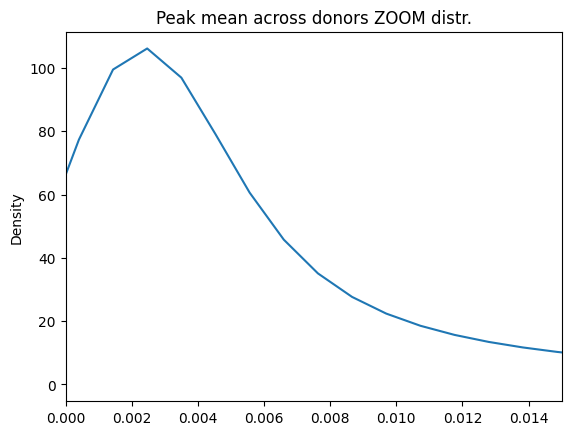

In [51]:
agg_mean.plot(kind='density',
              xlim=[0, 0.015],
              title="Peak mean across donors ZOOM distr.",
              xlabel="")

In [52]:
peaks_min_mean = set(agg_df.loc[:, agg_mean > min_peak_mean_adonors].columns.tolist())

## Peaks filter: min donors with non-zero ca count

In [53]:
non0s = (agg_df != 0).mean()

non0s.describe()

count    473392.000000
mean          0.326545
std           0.197881
min           0.044118
25%           0.176471
50%           0.264706
75%           0.426471
max           1.000000
dtype: float64

<Axes: title={'center': 'Non-zero donor count distr.'}, ylabel='#'>

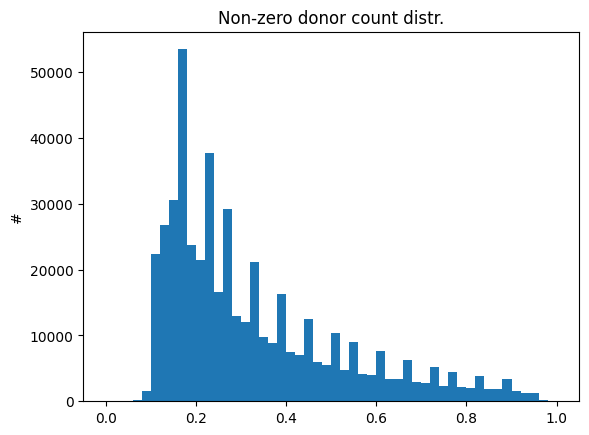

In [54]:
non0s.plot(kind='hist',
           bins=np.linspace(0, 1, 51),
           title="Non-zero donor count distr.",
           ylabel="#")

In [55]:
peaks_min_donors = set(agg_df.loc[:, non0s > min_donors].columns.to_list())

In [56]:
# Density of CA

non0 = np.count_nonzero(caPeaks_1ct_agg.X)
all_ = np.product(caPeaks_1ct_agg.X.shape)
general_ca_density = round(non0 / all_, 2)
print(f'General matrix density: {general_ca_density}')

General matrix density: 0.33


## Peaks filter: min peak score

In [57]:
peak_scores = caPeaks_1ct_agg.var['score']

In [58]:
peak_scores.describe()

count    473392.000000
mean         23.069922
std          33.490313
min           1.028790
25%           6.306620
50%          11.584100
75%          25.892100
max        1017.970000
Name: score, dtype: float64

<Axes: title={'center': 'Peak score distr.'}, ylabel='#'>

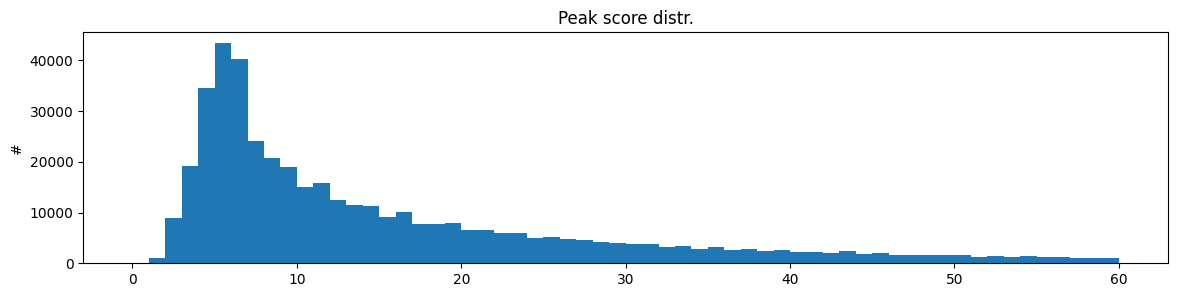

In [59]:
peak_scores.plot(kind='hist',
                 bins=np.linspace(0, 60, 61),
                 figsize=(14,3),
                 title="Peak score distr.",
                 ylabel="#")

In [60]:
peaks_min_score = set(caPeaks_1ct_agg.var[(caPeaks_1ct_agg.var['score'] >= min_score).tolist()].index.tolist())

In [61]:
del agg_df

## CA matrix: final peaks filtering step and export

In [62]:
print(f'Len peaks_hvp = {len(peaks_hvp)}\n' \
      f'peaks_hvp = {list(peaks_hvp)[0:4]}')

Len peaks_hvp = 381
peaks_hvp = ['chr1:155872383:155872883:501:*:39657', 'chr3:38649495:38649995:501:*:9988', 'chr5:88540079:88540579:501:*:18815', 'chr5:178153779:178154279:501:*:42766']


In [63]:
print(f'Len peaks_markers = {len(peaks_markers)}\n' \
      f'peaks_markers = {list(peaks_markers)[0:4]}')

Len peaks_markers = 2000
peaks_markers = ['chr10:3635402:3635902:501:*:1142', 'chr8:117372556:117373056:501:*:26896', 'chr3:170889562:170890062:501:*:42651', 'chr12:97886433:97886933:501:*:23862']


In [64]:
print(f'Len peaks_min_mean = {len(peaks_min_mean)}\n' \
      f'peaks_min_mean = {list(peaks_min_mean)[0:4]}')

Len peaks_min_mean = 335895
peaks_min_mean = ['chr5:124849607:124850107:501:*:27011', 'chr9:89219888:89220388:501:*:14586', 'chrX:72270433:72270933:501:*:10209', 'chr20:64083933:64084433:501:*:18518']


In [65]:
print(f'Len peaks_min_donors = {len(peaks_min_donors)}\n' \
      f'peaks_min_donors = {list(peaks_min_donors)[0:4]}')

Len peaks_min_donors = 314708
peaks_min_donors = ['chr5:124849607:124850107:501:*:27011', 'chrX:72270433:72270933:501:*:10209', 'chr20:64083933:64084433:501:*:18518', 'chr1:35702361:35702861:501:*:14814']


In [66]:
print(f'Len peaks_min_score = {len(peaks_min_score)}\n' \
      f'peaks_min_score = {list(peaks_min_score)[0:4]}')

Len peaks_min_score = 280934
peaks_min_score = ['chr3:52670773:52671273:501:*:14568', 'chr13:99198707:99199207:501:*:17548', 'chr16:19578385:19578885:501:*:6578', 'chrX:72270433:72270933:501:*:10209']


In [67]:
print(f'Len peaks_eqtl = {len(peaks_eqtl)}\n' \
      f'peaks_eqtl = {list(peaks_eqtl)[0:4]}')

Len peaks_eqtl = 332
peaks_eqtl = ['chr2:1140344:1140844:501:*:363', 'chr19:35141061:35141561:501:*:11375', 'chr6:138696820:138697320:501:*:33446', 'chr18:26645588:26646088:501:*:5477']


In [68]:
# Filter final peaks
final_peaks = list((peaks_hvp | peaks_markers | peaks_eqtl) & (peaks_min_mean | peaks_min_donors | peaks_min_score)) # remove peaks_min_mean or peaks_min_donors

caPeaks_1ct_agg = caPeaks_1ct_agg[:, final_peaks].copy()

len(final_peaks)

2664

In [69]:
# Create CA matrix
ca_peaks_out = caPeaks_1ct_agg.to_df().T
ca_peaks_out = ca_peaks_out.rename_axis('peak_id')

In [70]:
len(ca_peaks_out.columns.tolist())

68

In [71]:
ca_donors = list(set(ca_peaks_out.columns.tolist()) - artifact_donors) # Should be redundand
len(ca_donors)

68

In [72]:
ca_peaks_out = ca_peaks_out[ca_donors]

print(ca_peaks_out.shape)
ca_peaks_out

(2664, 68)


,SAMEA2658107,SAMEA2625592,SAMEA2609965,SAMEA2682671,SAMEA2698309,SAMEA2518334,SAMEA2459959,SAMEA2547622,SAMEA2658084,SAMEA2464819,...,SAMEA2518325,SAMEA3853122,SAMEA2547899,SAMEA3854308,SAMEA3847031,SAMEA3485962,SAMEA3966392,SAMEA3962624,SAMEA2433566,SAMEA2593858
peak_id,,,,,,,,,,,,,,,,,,,,,
chr10:3635402:3635902:501:*:1142,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr8:117372556:117373056:501:*:26896,0.000000,0.000000,0.008155,0.0,0.000000,0.0,0.0,0.001615,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.015536,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr3:170889562:170890062:501:*:42651,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr12:97886433:97886933:501:*:23862,0.000000,0.000000,0.000000,0.0,0.003918,0.0,0.0,0.000000,0.000000,0.0000,...,0.002225,0.000000,0.007897,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr3:38649495:38649995:501:*:9988,0.125138,0.472611,0.051098,0.0,0.061187,0.0,0.0,0.182594,0.118319,0.0789,...,0.117218,0.078049,0.132090,0.000000,0.033380,0.00000,0.029968,0.016140,0.000000,0.044802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr1:57712799:57713299:501:*:22012,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.009351,0.0000,...,0.005754,0.003513,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr17:5196900:5197400:501:*:2122,0.004506,0.000000,0.004020,0.0,0.010734,0.0,0.0,0.005943,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr10:514157:514657:501:*:165,0.096087,0.338753,0.091856,0.0,0.077379,0.0,0.0,0.127399,0.065342,0.0000,...,0.034292,0.049744,0.015050,0.233742,0.015608,0.01655,0.000000,0.091754,0.440774,0.069184


In [73]:
# Export peak chromatin accessibility
ca_peaks_out.round(6).to_csv(f"data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss_{cell_type}.tsv", sep='\t')

### CA matrix stats

In [74]:
_, mean_cells_donor, std_cells_donor, _, _, _, _, _ = caPeaks_1ct.obs.groupby('donor_id').size().describe()
_, mean_cells_donor_batch, std_cells_donor_batch, _, _, _, _, _ = caPeaks_1ct.obs.groupby(['donor_id', 'Batch']).size().describe() 

In [75]:
# Stats

with open("data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_stats.tsv", 'a') as f:
    
    msg = f'\n{RUN_ID}\t' \
            f'{cell_type}\t' \
            f'{general_ca_density}\t' \
            f'{n_cells}\t' \
            f'{n_donors}\t' \
            f'{mean_cells_donor}\t' \
            f'{std_cells_donor}\t' \
            f'{n_donor_batch}\t' \
            f'{mean_cells_donor_batch}\t' \
            f'{std_cells_donor_batch}\t' \
            f'{n_peaks_og}\t' \
            f'{n_peaks_min_cells}\t' \
            f'{n_peaks_post_min_cells}\t' \
            f'{len(peaks_eqtl)}\t' \
            f'{len(peaks_hvp)}\t' \
            f'{len(peaks_markers)}\t' \
            f'{len(peaks_min_mean)}\t' \
            f'{len(peaks_min_donors)}\t' \
            f'{len(peaks_min_score)}\t' \
            f'{ca_peaks_out.shape[0]}\t' \
            f'{ca_peaks_out.shape[1]}'

    
    f.write(msg)
    
    print(msg)


sep8	Differentiating-RG	0.33	4601	68	67.66176470588235	88.81165889143323	306	0.7354539641943734	5.896593284247622	736845	263453	473392	332	381	2000	335895	314708	280934	2664	68


In [76]:
del ca_peaks_out
del caPeaks_1ct

# COV: peak locations

In [77]:
peak_locs = caPeaks_1ct_agg.var[['peak_name', 'chr', 'start', 'end']].copy()
peak_locs['start'] = peak_locs['start'] - 1

peak_locs

,peak_name,chr,start,end
peak_name,,,,
chr10:3635402:3635902:501:*:1142,chr10:3635402:3635902:501:*:1142,chr10,3635401,3635902
chr8:117372556:117373056:501:*:26896,chr8:117372556:117373056:501:*:26896,chr8,117372555,117373056
chr3:170889562:170890062:501:*:42651,chr3:170889562:170890062:501:*:42651,chr3,170889561,170890062
chr12:97886433:97886933:501:*:23862,chr12:97886433:97886933:501:*:23862,chr12,97886432,97886933
chr3:38649495:38649995:501:*:9988,chr3:38649495:38649995:501:*:9988,chr3,38649494,38649995
...,...,...,...,...
chr1:57712799:57713299:501:*:22012,chr1:57712799:57713299:501:*:22012,chr1,57712798,57713299
chr17:5196900:5197400:501:*:2122,chr17:5196900:5197400:501:*:2122,chr17,5196899,5197400
chr10:514157:514657:501:*:165,chr10:514157:514657:501:*:165,chr10,514156,514657


In [78]:
peak_locs.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/peak_locations_{cell_type}.tsv", sep='\t', index=False)

In [79]:
del peak_locs

# COV: CA PCs

In [80]:
sc.pp.pca(caPeaks_1ct_agg) # Filtered for final peak set

In [81]:
ca_pcs = pd.DataFrame(caPeaks_1ct_agg.obsm['X_pca'][:, 0:20]).set_index(caPeaks_1ct_agg.obs_names)
ca_pcs.columns = [f'caPC_{str(i)}' for i in range(1, 21)]
ca_pcs = ca_pcs.T
ca_pcs = ca_pcs.rename_axis('id')

In [82]:
# ! Important that this doesn't change the sample nr! 2 cells above
ca_pcs = ca_pcs[ca_donors]

print(ca_pcs.shape)
ca_pcs

(20, 68)


,SAMEA2658107,SAMEA2625592,SAMEA2609965,SAMEA2682671,SAMEA2698309,SAMEA2518334,SAMEA2459959,SAMEA2547622,SAMEA2658084,SAMEA2464819,...,SAMEA2518325,SAMEA3853122,SAMEA2547899,SAMEA3854308,SAMEA3847031,SAMEA3485962,SAMEA3966392,SAMEA3962624,SAMEA2433566,SAMEA2593858
id,,,,,,,,,,,,,,,,,,,,,
caPC_1,-0.070244,-0.070723,-0.099642,-0.282857,-0.093615,-0.581849,-0.228893,-0.054966,-0.085384,0.098138,...,-0.052825,-0.171137,-0.015538,-0.252586,-0.093540,0.107633,0.024250,-0.031683,0.088689,-0.246085
caPC_2,-0.183997,0.587776,-0.106134,0.175121,-0.173307,-0.949623,0.282743,-0.172972,-0.158053,-0.097599,...,-0.218501,-0.168362,-0.157258,0.090245,-0.118966,-0.054756,-0.084849,-0.100307,-0.463272,-0.105472
caPC_3,0.011700,-0.298396,-0.062144,0.021397,0.023494,3.867503,0.754685,-0.022995,-0.033851,-0.464331,...,0.079796,-0.085721,-0.093469,-0.059779,-0.036897,-0.011258,0.028065,-0.002189,-0.150420,-0.079140
caPC_4,-0.152994,0.278634,-0.148090,0.273248,-0.098040,2.451911,-0.233440,-0.115551,-0.179307,-0.073279,...,-0.090366,-0.139980,-0.179774,-0.029964,0.141917,0.130057,-0.012099,-0.179872,-0.220586,-0.204643
caPC_5,-0.042987,0.728845,-0.079881,-0.448499,-0.041442,-0.646606,3.711204,-0.134306,0.026883,-0.288311,...,0.040434,-0.144830,-0.121941,0.190038,0.249893,-0.031560,-0.133650,-0.146340,0.221769,-0.040760
caPC_6,-0.231204,1.233285,-0.272778,1.923495,-0.253752,-0.066169,0.119873,-0.299551,-0.310381,0.066816,...,-0.213513,-0.132031,-0.282194,-0.005593,0.364798,0.237873,0.012563,-0.489026,-0.398047,-0.196310
caPC_7,-0.065472,-0.948621,-0.000624,-1.888865,-0.056516,0.320775,0.520392,-0.092679,0.058554,-0.244048,...,-0.104479,-0.131029,-0.077336,-0.136188,-0.043343,0.337030,0.280887,-0.182421,0.499564,0.060129
caPC_8,-0.023968,0.645796,-0.091943,-0.116752,-0.002983,0.217077,-0.034560,-0.102122,0.006968,-0.781559,...,0.045530,-0.001984,-0.110316,0.061590,0.153756,0.196177,0.089160,-0.032577,-0.668666,0.039576
caPC_9,-0.040458,1.587840,-0.031482,-0.643554,-0.003442,0.138303,-0.247376,0.004998,-0.143293,0.166306,...,0.010290,-0.027359,0.094765,-0.109000,-0.072660,-0.197232,-0.069079,0.100715,-0.374593,0.075646


In [83]:
ca_pcs.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/ca_pcs_{cell_type}.tsv", sep='\t')

In [84]:
del ca_pcs
del caPeaks_1ct_agg

# COV: Population structure

In [85]:
gt_pcs = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "Genotypes/GT_PCs.tsv"), sep="\t", index_col=0)
gt_pcs_matrixQTL = gt_pcs.T
gt_pcs_matrixQTL = gt_pcs_matrixQTL.rename_axis('id')
gt_pcs_matrixQTL = gt_pcs_matrixQTL[ca_donors]

print(gt_pcs_matrixQTL.shape)
gt_pcs_matrixQTL

(20, 68)


iid,SAMEA2658107,SAMEA2625592,SAMEA2609965,SAMEA2682671,SAMEA2698309,SAMEA2518334,SAMEA2459959,SAMEA2547622,SAMEA2658084,SAMEA2464819,...,SAMEA2518325,SAMEA3853122,SAMEA2547899,SAMEA3854308,SAMEA3847031,SAMEA3485962,SAMEA3966392,SAMEA3962624,SAMEA2433566,SAMEA2593858
id,,,,,,,,,,,,,,,,,,,,,
PC1,-3.758722,-36.099750,227.287930,16.612453,-587.087340,-5.666320,25.566353,-17.051203,-7.199219,11.102370,...,-424.345900,-43.581306,4.767535,15.455708,11.162530,26.002121,-42.349370,-39.436108,-43.615080,-10.252245
PC2,-17.553230,69.155190,292.474100,36.950134,367.275100,-7.982842,-0.801280,15.449395,13.413182,-18.024128,...,-333.008270,12.955510,42.741580,43.419895,-8.463341,45.160843,78.549210,11.223527,-25.593030,25.777967
PC3,-21.497366,54.365560,-196.692690,-0.269906,587.046800,30.781078,7.899430,-4.636946,46.895866,9.814706,...,1047.887000,45.188217,25.009369,29.958840,9.460196,15.704102,-1.863944,7.243265,14.852612,-45.328827
PC4,-10.106815,8.240096,-481.979950,24.004366,372.022800,13.758458,-15.956808,-16.699575,-19.546944,14.720867,...,201.116010,18.429962,-16.892120,-21.306501,9.443448,-34.477210,17.993840,19.611492,-36.705090,43.006980
PC5,-1.862093,-5.430482,-821.470460,28.637024,49.229893,-12.773034,9.408169,47.738790,-9.918574,16.440897,...,313.462860,27.995300,-39.381832,11.136854,-25.633224,-20.587145,-35.727848,16.133036,-60.274760,59.008102
PC6,10.962170,7.309116,-27.338608,-51.300888,-182.055220,-22.868008,-57.178745,-40.836580,6.438612,37.459100,...,916.074950,-35.752674,-43.932095,-12.994849,-13.197207,-7.275044,-13.191879,-32.406673,-35.062405,38.338024
PC7,7.909484,-14.493244,-599.690730,-23.499296,-386.220730,-44.276283,-33.235813,-20.985556,23.455002,-9.256178,...,72.117065,47.433018,11.173185,-0.985342,-39.513640,3.188169,-20.626287,23.316786,-22.549212,50.742157
PC8,32.048443,-20.599740,-20.858706,-45.816135,-129.463040,14.803077,-22.590284,-10.358272,14.720870,16.599375,...,-516.169000,85.883910,5.806158,-20.355007,-36.335648,0.363527,25.677296,-19.541563,69.714516,-12.687783
PC9,40.589954,6.205075,-9.215776,20.013197,-532.290700,-9.160951,38.184920,-21.179520,-2.595212,-28.210615,...,559.653140,-34.295834,56.597780,-37.755750,-7.582687,48.655170,-9.546488,-9.519834,43.126560,-9.142760


In [86]:
parent_dir = "data/datasets/hca_brain-organoids_processed/covariates/"

if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

In [87]:
gt_pcs_matrixQTL.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/genotype_pcs_{cell_type}.tsv", sep='\t')

In [88]:
del gt_pcs
del gt_pcs_matrixQTL

# Genotype

In [89]:
gt = pd.read_csv('data/datasets/hca_brain-organoids_processed/covariates/genotype.tsv', sep='\t', header=0, index_col=0).rename_axis('snp_id')
gt = gt.rename(index=lambda x: 'chr' + str(x))

In [90]:
snps_set = gt.index.tolist()

In [91]:
gt = gt[ca_donors]
gt

,SAMEA2658107,SAMEA2625592,SAMEA2609965,SAMEA2682671,SAMEA2698309,SAMEA2518334,SAMEA2459959,SAMEA2547622,SAMEA2658084,SAMEA2464819,...,SAMEA2518325,SAMEA3853122,SAMEA2547899,SAMEA3854308,SAMEA3847031,SAMEA3485962,SAMEA3966392,SAMEA3962624,SAMEA2433566,SAMEA2593858
snp_id,,,,,,,,,,,,,,,,,,,,,
chr1_89599_A_T,NaN,2.0,1.0,0.0,2.0,2.0,0.0,2.0,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
chr1_94986_C_T,0.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,NaN,1.0,...,2.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
chr1_94996_A_AT,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,...,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
chr1_95068_G_A,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
chr1_96305_C_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_50780959_T_C,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
chr22_50781276_G_A,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
chr22_50783303_T_C,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0


In [92]:
gt.to_csv(f'data/datasets/hca_brain-organoids_processed/covariates/genotype_NA_{cell_type}.tsv', sep='\t', na_rep='NaN')

In [93]:
del gt

# SNP locations

In [94]:
snps = pd.read_csv("data/datasets/hca_brain-organoids_processed/covariates/genotype.vcf",
                   sep="\t",
                   comment="#",
                   header=None,
                   names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMEA2536416", "SAMEA3854313", "SAMEA3853161", "SAMEA3966392", "SAMEA2625592", "SAMEA2698309", "SAMEA3962624", "SAMEA3965165", "SAMEA2595426", "SAMEA3962389", "SAMEA3973854", "SAMEA3847031", "SAMEA2547622", "SAMEA3854308", "SAMEA3964906", "SAMEA2536410", "SAMEA3735541", "SAMEA2590621", "SAMEA2698315", "SAMEA2445784", "SAMEA3973848", "SAMEA3962524", "SAMEA3485962", "SAMEA2609965", "SAMEA3851971", "SAMEA4089454", "SAMEA2613912", "SAMEA3963885", "SAMEA3963884", "SAMEA2613897", "SAMEA4089453", "SAMEA3851966", "SAMEA3974241", "SAMEA4343052", "SAMEA3962619", "SAMEA3853122", "SAMEA3974015", "SAMEA2518325", "SAMEA2433566", "SAMEA2459959", "SAMEA2675459", "SAMEA2682671", "SAMEA2645805", "SAMEA2711371", "SAMEA2593858", "SAMEA2445790", "SAMEA2518322", "SAMEA2547619", "SAMEA2627577", "SAMEA2547637", "SAMEA3977051", "SAMEA2445779", "SAMEA2609971", "SAMEA3974247", "SAMEA2658107", "SAMEA3754205", "SAMEA2547644", "SAMEA2678742", "SAMEA2474454", "SAMEA2627566", "SAMEA2518334", "SAMEA3967410", "SAMEA2536404", "SAMEA2627578", "SAMEA2518324", "SAMEA3968753", "SAMEA2547899", "SAMEA3754201", "SAMEA2570435", "SAMEA2658084", "SAMEA4451098", "SAMEA2678738", "SAMEA2547633", "SAMEA2609972", "SAMEA2707499", "SAMEA2555017", "SAMEA2420640", "SAMEA4451109", "SAMEA3448738", "SAMEA2627141", "SAMEA3485958", "SAMEA2536413", "SAMEA2464819", "SAMEA2627567", "SAMEA2645814"],
                   index_col=False
                  )

snps = snps[['ID', 'CHROM', 'POS']].rename(columns={'ID': 'snp_id', 'CHROM': 'chr', 'POS': 'pos'})
snps = snps.set_index('snp_id')

In [95]:
snps = snps.loc[snps_set]
snps

,chr,pos
snp_id,,
chr1_89599_A_T,chr1,89599
chr1_94986_C_T,chr1,94986
chr1_94996_A_AT,chr1,94996
chr1_95068_G_A,chr1,95068
chr1_96305_C_T,chr1,96305
...,...,...
chr22_50780959_T_C,chr22,50780959
chr22_50781276_G_A,chr22,50781276
chr22_50783303_T_C,chr22,50783303


In [96]:
snps.to_csv(f"data/datasets/hca_brain-organoids_processed/covariates/snp_locations_{cell_type}.tsv", sep='\t')

In [97]:
del snps